### Algorithm for the grouping of the data from the Medibio's ECG file set. 

#### written by Nicola Pastorello 16/11/2015
#### v.3.1 uses only profiles with reliable sleeping time extrapolation

In [1]:
library('party')

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


### DECISION TREE

In [2]:
originalDF = read.csv('metrics.csv')
# Check if missing data
is.na.data.frame <- function(obj){
                        sapply(obj,FUN = function(x) all(is.na(x)))
                        }
                            
isnt.finite.data.frame <- function(obj){
                        sapply(obj,FUN = function(x) all(!is.finite(x)))
                        }

           
badFit_DF = read.csv('BadFit.csv')
# isnt.finite.data.frame(DF)
# is.na.data.frame(DF)
        
# Remove useless columns
DF <- originalDF                         
DF$X <- NULL  
DF$ID <- NULL    
# Overwriting DF with only well fitted sleeping regions
DF_badfit <- DF[badFit_DF$BadFit == 'True', ]
DF_notfit <- DF[badFit_DF$BadFit == 'nan', ]
DF <- DF[badFit_DF$BadFit == 'False', ]
                               
                               
nDF <- DF
nDF_test_NF <- DF_notfit

set.seed(20)
splitSample = sample(rep(1:2, length(nDF$Gini_diff)/2.)) 
nDF_test <- nDF[splitSample == 2,]
nDF <- nDF[splitSample == 1,]

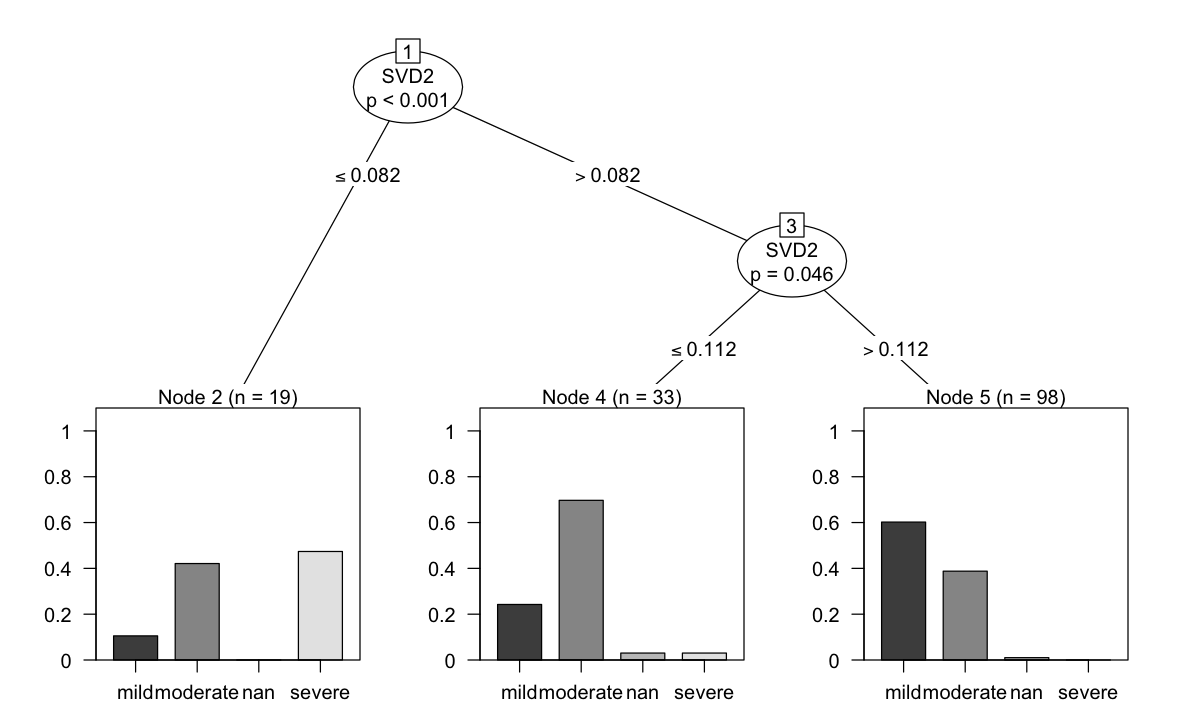

In [3]:
tree <- ctree(label ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std + 
              Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility + 
              Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30, data=DF)

options(repr.plot.width=10, repr.plot.height=6)
plot(tree)#, type="simple")

# There are some Stress levels not provided. Trying to obtain them via decision trees. 
# pred <- predict(tree, DF[which(DF$label == 'nan'),]) 
# nDF <- DF
# nDF[which(DF$label == 'nan'),]$label <- pred

# nDF$label <- factor(nDF$label)
# DF_notfit$label <- factor(DF_notfit$label)


### Random Forest

In [ ]:
# Using the randomForest package (purity measure)
# Following: http://trevorstephens.com/post/73770963794/titanic-getting-started-with-r-part-5-random
library(randomForest)

set.seed(13124) # Setting a static seed will allow the results' reproducibility

# Separate sample in training and test
bound <- floor((nrow(nDF)/10)*9)                         #define % of training and test set
selectedDF <- nDF[sample(nrow(nDF),#),] #sample rows,
                   replace = TRUE), ]     #     Typically 37% will be left out
selectedDF.train <- selectedDF[1:bound, ]              #get training set
selectedDF.test <- selectedDF[(bound+1):nrow(selectedDF), ]    #get test set


# drops the empty level in the factor
selectedDF.sub <- subset(selectedDF.train, label %in% c("moderate", "mild", "severe"))
selectedDF.sub$label <- factor(selectedDF.sub$label)


fitRF <- randomForest(as.factor(label) ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std  
                                      + Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility 
                                      + Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30
                    , data=selectedDF.sub, importance=TRUE, ntree=2000)

In [ ]:
# Test which parameters are the most predictive (which variables are the most important)
varImpPlot(fitRF)

In [ ]:
# Check predictions on test dataset
Prediction_RF <- predict(fitRF, selectedDF.test, type='response')

diff = c(Prediction_RF)-c(selectedDF.test$label)
fracLarge = sum(abs(diff) <= 1)/sum(diff > -10)*100
fracStrict = sum(abs(diff) <= 0)/sum(diff > -10)*100
print("Fraction of recognized MILD/MODERATE and MODERATE/SEVERE")
print(fracLarge)
print("Fraction of recognized MILD, MODERATE and SEVERE")
print(fracStrict)

In [ ]:
set.seed(342)
fit <- cforest(as.factor(label) ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std  
                                      + Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility 
                                      + Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30,
               data = selectedDF.sub, controls=cforest_unbiased(ntree=2000, mtry=5))#mtry should be around sqrt(ncols)


In [ ]:
Prediction_party <- predict(fit, selectedDF.test, OOB=TRUE, type = "response")

diff = c(Prediction_party)-c(selectedDF.test$label)
fracLarge = sum(abs(diff) <= 1)/sum(diff > -10)*100
fracStrict = sum(abs(diff) <= 0)/sum(diff > -10)*100
print("Fraction of recognized MILD/MODERATE and MODERATE/SEVERE")
print(fracLarge)
print("Fraction of recognized MILD, MODERATE and SEVERE")
print(fracStrict)

#### Run 10-fold validation (or N-fold validation) for random forest

In [ ]:
library(cvTools) 
k <- 10 #the number of folds

folds <- cvFolds(NROW(nDF), K=k)
nDF$holdoutpred <- rep(0,nrow(nDF))  # Array with predictions

for(i in 1:k){
    train <- nDF[folds$subsets[folds$which != i], ] #Set the training set
    validation <- nDF[folds$subsets[folds$which == i], ] #Set the validation set

    set.seed(i*1231)
    fit <- cforest(as.factor(label) ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std  
                                      + Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility 
                                      + Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30,
               data = train, controls=cforest_unbiased(ntree=2000, mtry=3))
    
    #Get the predicitons for the validation set (from the model just fit on the train data)
    newpred <- predict(fit, newdata=validation)
    #Put the hold out prediction in the data set for later use
    nDF[folds$subsets[folds$which == i], ]$holdoutpred <- newpred 
}

In [ ]:
# Check resulting predictions

check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(nDF$holdoutpred[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere
fracStressed = (sum(check[(nDF$label == 'severe') | (nDF$label == 'moderate')])/
                length(check[(nDF$label == 'severe') | (nDF$label == 'moderate')]))
fracStressed

#### Run 10-fold validation (or N-fold validation) for Decision tree

In [ ]:
library(cvTools) 
k <- 10 #the number of folds

folds <- cvFolds(NROW(nDF), K=k)
nDF$holdoutpred <- rep(0,nrow(nDF))  # Array with predictions

for(i in 1:k){
    train <- nDF[folds$subsets[folds$which != i], ] #Set the training set
    validation <- nDF[folds$subsets[folds$which == i], ] #Set the validation set

    set.seed(i*1231)
    fit <- ctree(label ~ DFA_dt + Entropy_sleep + Entropy_tot + slope + FT_std + 
              Gini_diff + Gini_dt + Gini_t + H_complexity + H_mobility + 
              Hjorth + Hurst + Petrosian + std_DT +
              SVD2 + SVD3 + SVD5 + SVD10 + SVD15 + SVD20 + SVD25 + SVD30, data=train)
    
    #Get the predicitons for the validation set (from the model just fit on the train data)
    newpred <- predict(fit, newdata=validation)
    #Put the hold out prediction in the data set for later use
    nDF[folds$subsets[folds$which == i], ]$holdoutpred <- newpred 
}

In [ ]:
# Check resulting predictions

check <- rep(0, nrow(nDF))
for(i in 1:nrow(nDF)){
    if(c(nDF$label[i])-c(nDF$holdoutpred[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF$label == 'mild'])/length(check[nDF$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF$label == 'moderate'])/length(check[nDF$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF$label == 'severe'])/length(check[nDF$label == 'severe'])
fracSevere

### Trying with different libraries

#### caret

In [5]:
library(caret)
library(e1071)
#remove object with NAN
nDF <- na.omit(DF)
train <- createFolds(nDF$label, k=10)

Loading required package: lattice
Loading required package: ggplot2


In [7]:
ctreeFit <- train(label ~ ., method = "ctree", data = nDF,
    tuneLength = 15,
    trControl = trainControl(
        method = "cv", indexOut = train))

Conditional Inference Tree 

150 samples
 22 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 136, 135, 135, 135, 134, 135, ... 
Resampling results across tuning parameters:

  mincriterion  Accuracy   Kappa      Accuracy SD  Kappa SD 
  0.01          0.7194643  0.5168753  0.1091681    0.1850897
  0.08          0.6802381  0.4460824  0.1037700    0.1859248
  0.15          0.6602381  0.4134738  0.1239814    0.2108194
  0.22          0.6602381  0.4134738  0.1239814    0.2108194
  0.29          0.6602381  0.4134738  0.1239814    0.2108194
  0.36          0.6602381  0.4134738  0.1239814    0.2108194
  0.43          0.6406548  0.3810680  0.1252127    0.2091175
  0.50          0.6477976  0.3950161  0.1181347    0.1902719
  0.57          0.6544643  0.4069209  0.1211602    0.1946239
  0.64          0.6544643  0.4069209  0.1211602    0.1946239
  0.71          0.6144643  0.3319209  0.1087077    0.1922202

[1] moderate mild     moderate moderate mild     mild     mild     moderate
 [9] mild     mild    
Levels: mild moderate nan severe

[1] moderate mild     moderate moderate mild     mild     mild     moderate
 [9] mild     mild    
Levels: mild moderate nan severe

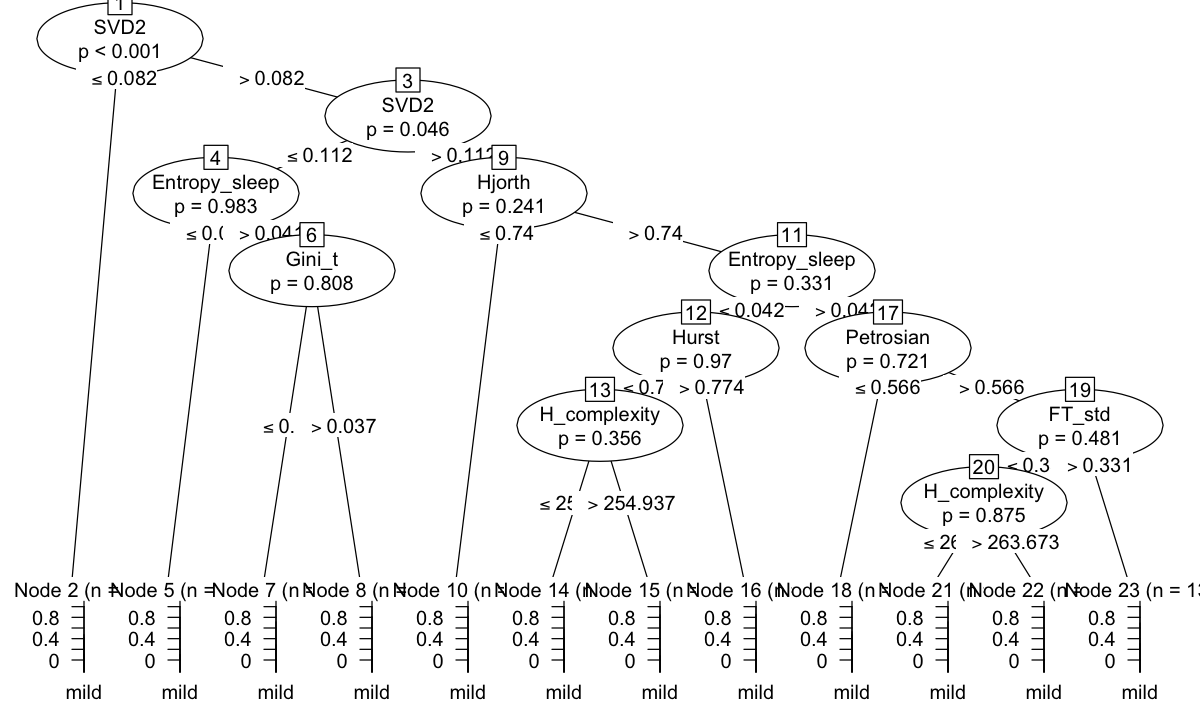

In [8]:
ctreeFit
plot(ctreeFit$finalModel)
predict(ctreeFit, nDF[1:10,])
nDF[1:10,]$label

#### RWeka

In [11]:
library(RWeka)

set.seed(218651) 
C45Fit <- train(label ~ ., method = "J48", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train))
C45Fit
C45Fit$finalModel

C4.5-like Trees 

150 samples
 22 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 135, 135, 135, 135, 135, 135, ... 
Resampling results

  Accuracy   Kappa     Accuracy SD  Kappa SD
  0.8290476  0.701588  0.1377475    0.243844

Tuning parameter 'C' was held constant at a value of 0.25
 

J48 pruned tree
------------------

SVD2 <= 0.081731
|   Gini_t <= 0.025692
|   |   slope <= 0.001451: moderate (7.0)
|   |   slope > 0.001451: severe (4.0/1.0)
|   Gini_t > 0.025692
|   |   Gini_t <= 0.032098: mild (2.0)
|   |   Gini_t > 0.032098: severe (6.0)
SVD2 > 0.081731
|   Gini_diff <= 0.006869
|   |   DFA_dt <= 0.473597: mild (18.0/1.0)
|   |   DFA_dt > 0.473597
|   |   |   Hjorth <= 0.831538: moderate (38.0/14.0)
|   |   |   Hjorth > 0.831538
|   |   |   |   slope <= 0.007003
|   |   |   |   |   SVD3 <= 0.184715
|   |   |   |   |   |   SVD10 <= 0.467656: mild (2.0)
|   |   |   |   |   |   SVD10 > 0.467656: moderate (4.0/1.0)
|   |   |   |   |   SVD3 > 0.184715
|   |   |   |   |   |   H_complexity <= 233.760873: moderate (3.0/1.0)
|   |   |   |   |   |   H_complexity > 233.760873: mild (22.0)
|   |   |   |   slope > 0.007003
|   |   |   |   |   std_DT <= 0.082556
|   |   |   |   |   |   Gini_diff <= -0.002826: mild (4.0)
|   |   |   |   |   |   Gini_diff > -0.002826: moderate 

In [12]:
# Check resulting predictions
predictedC45 <- predict(C45Fit, nDF_test)
check <- rep(0, nrow(nDF_test))
for(i in 1:nrow(nDF_test)){
    if(c(nDF_test$label[i])-c(predictedC45[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_test$label == 'mild'])/length(check[nDF_test$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF_test$label == 'moderate'])/length(check[nDF_test$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF_test$label == 'severe'])/length(check[nDF_test$label == 'severe'])
fracSevere

[1] 0.7333333

[1] 1

[1] 1

In [13]:
# PART (Rule-based classifier)
rulesFit <- train(label ~ ., method = "PART", data = nDF,
  tuneLength = 5,
  trControl = trainControl(
    method = "cv", indexOut = train))
rulesFit
rulesFit$finalModel

Rule-Based Classifier 

150 samples
 22 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 136, 135, 135, 135, 134, 135, ... 
Resampling results

  Accuracy   Kappa     Accuracy SD  Kappa SD 
  0.8254167  0.687579  0.08927163   0.1612481

Tuning parameter 'threshold' was held constant at a value of 0.25

Tuning parameter 'pruned' was held constant at a value of yes
 

PART decision list
------------------

SVD2 > 0.081731 AND
Gini_diff > 0.006869 AND
Hurst <= 0.796924 AND
Gini_diff > 0.007859 AND
Gini_t <= 0.081341: moderate (21.0)

SVD2 > 0.081731 AND
Entropy_sleep > 0.044984 AND
slope <= 0.001451 AND
Hurst <= 0.769216: mild (31.0)

SVD2 > 0.081731 AND
Hurst > 0.705548: moderate (61.0/27.0)

SVD10 <= 0.530479 AND
Gini_t > 0.025692 AND
Gini_t > 0.032098: severe (7.0)

Gini_t <= 0.025692 AND
slope <= 0.001451: moderate (7.0)

Gini_t > 0.025669: mild (20.0/9.0)

: severe (3.0)

Number of Rules  : 	7


In [16]:
# Check resulting predictions
predictedRules <- predict(rulesFit, nDF_test)
check <- rep(0, nrow(nDF_test))
for(i in 1:nrow(nDF_test)){
    if(c(nDF_test$label[i])-c(predictedRules[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_test$label == 'mild'])/length(check[nDF_test$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF_test$label == 'moderate'])/length(check[nDF_test$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF_test$label == 'severe'])/length(check[nDF_test$label == 'severe'])
fracSevere


[1] 0.6

[1] 0.8974359

[1] 1

[1] 4

In [17]:
# Linear Support Vector Machines
svmFit <- train(label ~., method = "svmLinear", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train))
svmFit
svmFit$finalModel

Support Vector Machines with Linear Kernel 

150 samples
 22 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 135, 135, 135, 136, 135, 135, ... 
Resampling results

  Accuracy   Kappa      Accuracy SD  Kappa SD 
  0.7202976  0.4981498  0.1009936    0.1846814

Tuning parameter 'C' was held constant at a value of 1
 

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Linear (vanilla) kernel function. 

Number of Support Vectors : 114 

Objective Function Value : -80.0074 -3.3034 -3.3336 -3.1106 -16.1554 -0.4304 
Training error : 0.266667 

In [18]:
# Check resulting predictions
predictedSVM <- predict(svmFit, nDF_test)
check <- rep(0, nrow(nDF_test))
for(i in 1:nrow(nDF_test)){
    if(c(nDF_test$label[i])-c(predictedSVM[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_test$label == 'mild'])/length(check[nDF_test$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF_test$label == 'moderate'])/length(check[nDF_test$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF_test$label == 'severe'])/length(check[nDF_test$label == 'severe'])
fracSevere

[1] 0.6666667

[1] 0.7435897

[1] 0.75

In [19]:
# Artificial Neural Network
nnetFit <- train(label ~ ., method = "nnet", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv"
        , indexOut = train))
nnetFit
nnetFit$finalModel

Loading required package: nnet


# weights:  31
initial  value 224.692227 
iter  10 value 124.770848
iter  10 value 124.770848
iter  10 value 124.770848
final  value 124.770848 
converged
# weights:  85
initial  value 262.753366 
iter  10 value 128.268032
final  value 124.770848 
converged
# weights:  139
initial  value 249.941831 
iter  10 value 125.695541
final  value 124.770848 
converged
# weights:  193
initial  value 235.832544 
iter  10 value 124.770866
final  value 124.770848 
converged
# weights:  247
initial  value 147.410901 
iter  10 value 124.770856
final  value 124.770849 
converged
# weights:  31
initial  value 220.658211 
iter  10 value 125.822961
iter  20 value 124.826173
iter  30 value 118.015895
iter  40 value 114.107228
iter  50 value 113.873444
final  value 113.873356 
converged
# weights:  85
initial  value 219.325246 
iter  10 value 125.675071
iter  20 value 125.178641
iter  30 value 123.188993
iter  40 value 113.922323
iter  50 value 113.109182
iter  60 value 113.095352
final  value 113.095346 


Neural Network 

150 samples
 22 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 134, 136, 135, 135, 135, 136, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa        Accuracy SD  Kappa SD 
  1     0e+00  0.4817262   0.03718986  0.08572992   0.1500180
  1     1e-04  0.4488095  -0.02358182  0.14283978   0.2654523
  1     1e-03  0.5673810   0.22229602  0.16720171   0.3019007
  1     1e-02  0.6156548   0.30224747  0.12912324   0.2349226
  1     1e-01  0.5805357   0.21537217  0.08426074   0.1604769
  3     0e+00  0.4242857  -0.07472952  0.12820280   0.2513447
  3     1e-04  0.4604167  -0.01388889  0.09524275   0.1759259
  3     1e-03  0.5923214   0.26428145  0.15952589   0.2981405
  3     1e-02  0.6356548   0.33974747  0.10530031   0.1834317
  3     1e-01  0.5853571   0.24135080  0.12529104   0.2431153
  5     0e+00  0.5026190   0.08808140  0.14884820   0.2786320

a 22-7-4 network with 193 weights
inputs: DFA_dt Entropy_sleep Entropy_tot FT_std Gini_diff Gini_dt Gini_t H_complexity H_mobility Hjorth Hurst Petrosian SVD10 SVD15 SVD2 SVD20 SVD25 SVD3 SVD30 SVD5 slope std_DT 
output(s): .outcome 
options were - softmax modelling  decay=0.01

In [20]:
# Check resulting predictions
predictedNN <- predict(nnetFit, nDF_test)
check <- rep(0, nrow(nDF_test))
for(i in 1:nrow(nDF_test)){
    if(c(nDF_test$label[i])-c(predictedNN[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_test$label == 'mild'])/length(check[nDF_test$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF_test$label == 'moderate'])/length(check[nDF_test$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF_test$label == 'severe'])/length(check[nDF_test$label == 'severe'])
fracSevere

[1] 0.6666667

[1] 0.6410256

[1] 0

In [23]:
# Random Forest
randomForestFit <- train(label ~ ., method = "rf", data = nDF,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train))
randomForestFit
randomForestFit$finalModel

Random Forest 

150 samples
 22 predictor
  4 classes: 'mild', 'moderate', 'nan', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 135, 135, 135, 134, 136, 135, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa      Accuracy SD  Kappa SD  
   2    0.9675000  0.9433626  0.06433420   0.11419782
   7    0.9675000  0.9433626  0.04651430   0.08211167
  12    0.9675000  0.9433626  0.04651430   0.08211167
  17    0.9675000  0.9433626  0.04651430   0.08211167
  22    0.9741667  0.9552674  0.04584596   0.08067525

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 22. 


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 22

        OOB estimate of  error rate: 43.33%
Confusion matrix:
         mild moderate nan severe class.error
mild       40       28   0      1   0.4202899
moderate   23       44   0      2   0.3623188
nan         1        1   0      0   1.0000000
severe      0        9   0      1   0.9000000

In [24]:
# Check resulting predictions
predictedRF <- predict(randomForestFit, nDF_test)
check <- rep(0, nrow(nDF_test))
for(i in 1:nrow(nDF_test)){
    if(c(nDF_test$label[i])-c(predictedRF[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_test$label == 'mild'])/length(check[nDF_test$label == 'mild'])
fracMild  
fracModerate = sum(check[nDF_test$label == 'moderate'])/length(check[nDF_test$label == 'moderate'])
fracModerate
fracSevere = sum(check[nDF_test$label == 'severe'])/length(check[nDF_test$label == 'severe'])
fracSevere

[1] 1

[1] 1

[1] 1

In [ ]:
# Comparing models
resamps <- resamples(list(
  C45=C45Fit,
  SVM=svmFit,
  #KNN=knnFit,
  rules=rulesFit,
  NeuralNet=nnetFit,
  randomForest=randomForestFit))
resamps
summary(resamps)

In [ ]:
difs <- diff(resamps)
summary(difs)

In [ ]:
# Comparing predictions for single cases
nDF_test$best_voted <- 99
for (index in 1:length(nDF_test$Gini_t)) {
    check <- c(#predict(C45Fit, nDF_test[index,]),
#                predict(svmFit, nDF_test[index,]), 
#                predict(rulesFit, nDF_test[index,]), 
#                 predict(nnetFit, nDF_test[index,]),
               predict(randomForestFit, nDF_test[index,])
              )
    best_voted <- names(sort(table(check),decreasing=TRUE))[1]
    nDF_test$best_voted[index] <- best_voted
}

In [ ]:
diff = as.numeric(nDF_test$best_voted)-c(nDF_test$label)
(length(which(diff!=0))/ length(nDF_test$Gini_t))*100

In [ ]:
# Trying with the test set built with the wrong sleeping regions
DF_badfit$best_voted <- 99
for (index in 1:length(DF_badfit$ID)) {
    check <- c(predict(C45Fit, DF_badfit[index,]),
               predict(svmFit, DF_badfit[index,]),
               predict(rulesFit, DF_badfit[index,]),
               predict(nnetFit, DF_badfit[index,]),
               predict(randomForestFit, DF_badfit[index,])
              )
    best_voted <- names(sort(table(check),decreasing=TRUE))[1]
    DF_badfit$best_voted[index] <- best_voted
}
diff = as.numeric(DF_badfit$best_voted)-c(DF_badfit$label)
100-(length(which(diff!=0))/ length(DF_badfit$ID))*100

### Multidimensional scaling
##### (useful to separate the points in the Hjorth mobility and complexity scatter plot ???)

In [ ]:
# ...work in progress